# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral Cloning



---
## Step 0: include libraries, define helper functions and constants

In [1]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

### helper functions
# function implements the data augmentation
def data_augmentation(images, angles):
    aug_images, aug_angles = [], []
        
    # flipping
    for image, angle in zip(images, angles):
        aug_images.append(image)
        aug_angles.append(angle)
        aug_images.append(cv2.flip(image,1))
        aug_angles.append(angle*-1.0)

    return aug_images, aug_angles

# function with using of the generator in sense of python 
def generator(samples, batch_size=128):
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0].split('\\')[-1]
                path = './data_own/IMG/' + name
                center_image = cv2.imread(path)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
            # save the input data as numpy-arrays
            X_train = np.array(images)
            y_train = np.array(angles)
            #print(path)
            #print("Offset:", offset)
            yield sklearn.utils.shuffle(X_train, y_train)
            #yield images, angles

### constants 
# define sets for trainig and for validation
TRAIN_RATIO = 0.2
BATCH_SIZE = 128 # 32 #64 
EPOCHS = 15
# rows pixels from the top of the image
TOP_RAWS = 74
# rows pixels from the bottom of the image
BOTTOM_RAWS = 20
# columns of pixels from the left of the image
LEFT_COLS = 0
# columns of pixels from the right of the image
RIGHT_COLS = 0

# input image format
ch, row, col = 3, 160, 320

Using TensorFlow backend.


---

## Step 1: Load images and prepeare sets for training and validation 


In [2]:
### main run routine
samples = []
with open('./data_own/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


# split sets for training and validation
train_samples, validation_samples = train_test_split(samples, test_size=TRAIN_RATIO)
print("Number of samples for training: ", len(train_samples))
print("Number of samples for validation: ", len(validation_samples))

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

#next(train_generator)

Number of samples for training:  4567
Number of samples for validation:  1142


----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

In [3]:
#### Pre-process all data
# grayscale conversion
# * img: input images to preprocess
# * return: preprocessed images
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# adaptive histogram equalization
# * img: input images to preprocess
# * clahe: CLAHE object (Contrast Limited Adaptive Histogram Equalization)
# * return: preprocessed images
def hist_equalization(img, clahe):
    img = img.astype(np.uint8)
    img = img.squeeze()
    #img = cv2.equalizeHist(img)
    img = clahe.apply(img)
    return img

# preprocess function
# * img_arr: input array of images to process
# * return: output array with preprocessed images
def preprocess_image_array(img_arr):
    # init the new numpy array
    img_arr_new = np.empty(img_arr.shape[:3])
    # create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for i in range (len(img_arr)):
        # convert the input RGB-images in grayscale-format
        img_arr_new[i] = rgb2gray(img_arr[i]) # cv2.cvtColor(img_arr[i], cv2.COLOR_BGR2GRAY)
        # apply the histogram equalization
        img_arr_new[i] = hist_equalization(img_arr_new[i], clahe)
    # normalize     
    img_arr_new = img_arr_new / 255 #(img_arr_new - 128) / 128
    return img_arr_new



### Model Architecture

In [4]:
keras_old_ver = 1
model = Sequential()
# define the architecture of the model based on NVIDIA CNN-Architecture
# pre-process incoming data, trimming of the image 
model.add(Cropping2D(cropping=((TOP_RAWS,BOTTOM_RAWS),(LEFT_COLS,RIGHT_COLS)), input_shape=(row, col, ch)))
# pre-process incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: ( x / 255.0 ) - 0.5))

if keras_old_ver:
    # Layer Conv1, input shape: 3x66x320
    model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv2, input shape: 24x31x158 
    model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv3, input shape: 36x14x77
    model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv4, input shape: 48x5x36
    model.add(Convolution2D(64, 3, 3))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv5, input shape: 64x3x34
    model.add(Convolution2D(64, 3, 3))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
else:
    # Layer Conv1, input shape: 3x66x320
    model.add(Convolution2D(24, (5, 5), strides=2))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv2, input shape: 24x31x158 
    model.add(Convolution2D(36, (5, 5), strides=2))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv3, input shape: 36x14x77
    model.add(Convolution2D(48, (5, 5), strides=2))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv4, input shape: 48x5x36
    model.add(Convolution2D(64, (3, 3)))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # Layer Conv5, input shape: 64x3x34
    model.add(Convolution2D(64, (3, 3)))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    
# Layer Conv6, input shape: 64x1x32
model.add(Flatten())
# Layer Fully connected 7, input shape: 2048
model.add(Dense(160))
model.add(Dropout(0.5))
model.add(Activation('relu'))
# Layer Fully connected 8, input shape: 160
model.add(Dense(80))
model.add(Dropout(0.5))
model.add(Activation('relu'))
# Layer Fully connected 9, input shape: 80
model.add(Dense(16))
model.add(Dropout(0.5))
model.add(Activation('relu'))
# Layer Fully connected 10, input shape: 16
model.add(Dense(1))
#print(model.get_config())

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Epoch 1/15
Offset: 0
Offset: 128
Offset: 256
Offset: 384
Offset: 512
Offset: 640
Offset: 768
 128/4567 [..............................] - ETA: 84s - loss: 0.1579Offset: 896
Offset: 1024
Offset: 1152
Offset: 1280
 256/4567 [>.............................] - ETA: 61s - loss: 0.1597Offset: 1408
Offset: 1536
4480/4567 [============================>.] - ETA: 0s - loss: 0.1429Offset: 1152
Offset: 0
Offset: 128
Offset: 256
Offset: 384
Offset: 512
Offset: 640
Offset: 768
Offset: 896
Offset: 1024
Offset: 0
Offset: 128
Offset: 256
Offset: 384
4567/4567 [==============================] - 46s - loss: 0.1429 - val_loss: 0.1181
Epoch 2/15
Offset: 1280
4480/4567 [============================>.] - ETA: 0s - loss: 0.1272Offset: 1152
Offset: 512
Offset: 640
Offset: 768
Offset: 896
Offset: 1024
Offset: 0
Offset: 128
Offset: 256
Offset: 384
Offset: 512
Offset: 640
Offset: 768
Offset: 896
Offset: 1024
Offset: 0
Offset: 128
Offset: 256
Offset: 384
Offset: 512
4567/4567 [==============================] - 45s

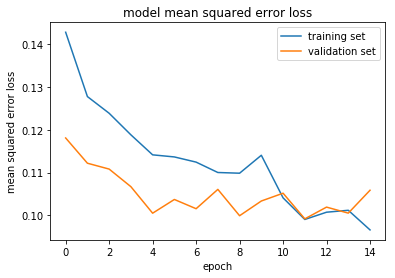

In [5]:
# train the model
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples), validation_data=validation_generator, \
            nb_val_samples=len(validation_samples), nb_epoch=EPOCHS, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')   
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


In [6]:
# save the trained model
model.save('model.h5')
print("Model saved")

Model saved


---

## Visualize the Neural Network's State with Test Images


In [7]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

import math

#--------------------------
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    activation = sess.run(tf_activation, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
#with tf.Session() as sess:
    #saver.restore(sess, save_file)
    #conv2_map = sess.run(conv2_W, feed_dict={x: X_test_gray_own})
    #print(sess.run(conv2_W))
    #outputFeatureMap([X_test_gray_own[6]], conv1, plt_num=1)
    #outputFeatureMap([X_test_gray_own[6]], conv2, plt_num=2)

NameError: name 'tf' is not defined